In [21]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

In [3]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [4]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [5]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

In [6]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


In [7]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.lr=lr
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0


    def step(self):
      self.t += 1
      with torch.no_grad():
        for i, p in enumerate(self.params):
          gradient=p.grad
          if gradient is None:
            continue
          self.m[i]=self.beta1*self.m[i]+(1-self.beta1)*gradient
          self.v[i]=self.beta2*self.v[i]+(1-self.beta2)*gradient**2

          m_hat=self.m[i]/(1-self.beta1**self.t)
          v_hat=self.v[i]/(1-self.beta2**self.t)



          p -=self.lr*m_hat/(torch.sqrt(v_hat)+self.epsilon)

In [8]:
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, lymbda=0.01):
        super().__init__(params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.lr=lr
        self.m = [torch.zeros(p.shape) for p in self.params]
        self.v = [torch.zeros(p.shape) for p in self.params]
        self.t = 0
        self.lymbda=lymbda


    def step(self):
      self.t += 1
      with torch.no_grad():
        for i, p in enumerate(self.params):
          gradient=p.grad
          if gradient is None:
            continue
          self.m[i]=self.beta1*self.m[i]+(1-self.beta1)*gradient
          self.v[i]=self.beta2*self.v[i]+(1-self.beta2)*gradient**2

          m_hat=self.m[i]/(1-self.beta1**self.t)
          v_hat=self.v[i]/(1-self.beta2**self.t)



          p -=self.lr*m_hat/(torch.sqrt(v_hat)+self.epsilon)
          p -= self.lr * self.lymbda * p


In [9]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-10-01 11:19:58--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-10-01 11:19:58--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [   <=>              ]  33.20M  55.5MB/s    in 0.6s    

2025-10-01 11:19:59 (55.5 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [10]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

In [11]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def step(self):
        pass

In [12]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters
        self.step_count = 0
        self.base_lr = optimizer.lr

    def step(self):
        self.step_count+=1
        if self.step_count<=self.total_iters:
          factor=self.start_factor+(self.step_count-1)/self.total_iters*(self.end_factor-self.start_factor)
        else:
          factor=self.end_factor
        self.optimizer.lr = self.base_lr * factor

class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.lr
        self.step_count = 0


    def step(self):
      self.step_count+=1
      lr = self.eta_min + (self.base_lr - self.eta_min) * (1 + math.cos(math.pi * (self.step_count - 1) / self.T_max)) / 2
      self.optimizer.lr = lr


In [18]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [14]:
def train(model, optimizer, scheduler=None, n_epochs=10):
    train_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        # Обучение
        model.train()
        epoch_loss = 0.0
        for x_train, y_train in tqdm(train_loader):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = nn.functional.nll_loss(y_pred, y_train)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_val, y_val in test_loader:
                y_pred = model(x_val)
                pred = y_pred.argmax(dim=1)
                correct += (pred == y_val).sum().item()
                total += y_val.size(0)

        accuracy = correct / total
        train_losses.append(avg_loss)
        test_accuracies.append(accuracy)

        if scheduler is not None:
            scheduler.step()
    return train_losses, test_accuracies

In [27]:
experiments = [
    ('SGD', lambda p: SGD(p, lr=0.01), None),
    ('Adam', lambda p: Adam(p, lr=0.001), None),
    ('AdamW', lambda p: AdamW(p, lr=0.001, lymbda=0.01), None),

    ('SGD+Linear', lambda p: SGD(p, lr=0.01), lambda opt: LinearLR(opt, start_factor=0.1, total_iters=10)),
    ('Adam+Linear', lambda p: Adam(p, lr=0.001), lambda opt: LinearLR(opt, start_factor=0.1, total_iters=10)),
    ('AdamW+Linear', lambda p: AdamW(p, lr=0.001, lymbda=0.01), lambda opt: LinearLR(opt, start_factor=0.1, total_iters=10)),

    ('SGD+Cosine', lambda p: SGD(p, lr=0.01), lambda opt: CosineAnnealing(opt, T_max=20, eta_min=0.0001)),
    ('Adam+Cosine', lambda p: Adam(p, lr=0.001), lambda opt: CosineAnnealing(opt, T_max=20, eta_min=0.0001)),
    ('AdamW+Cosine', lambda p: AdamW(p, lr=0.001, lymbda=0.01), lambda opt: CosineAnnealing(opt, T_max=20, eta_min=0.0001)),
]

results = {}
for name, opt_fn, sched_fn in experiments:
    model = CNN()
    optimizer = opt_fn(model.parameters())
    scheduler = sched_fn(optimizer) if sched_fn else None
    losses, accs = train(model, optimizer, scheduler, n_epochs=5)
    results[name] = {'losses': losses, 'accuracies': accs}


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

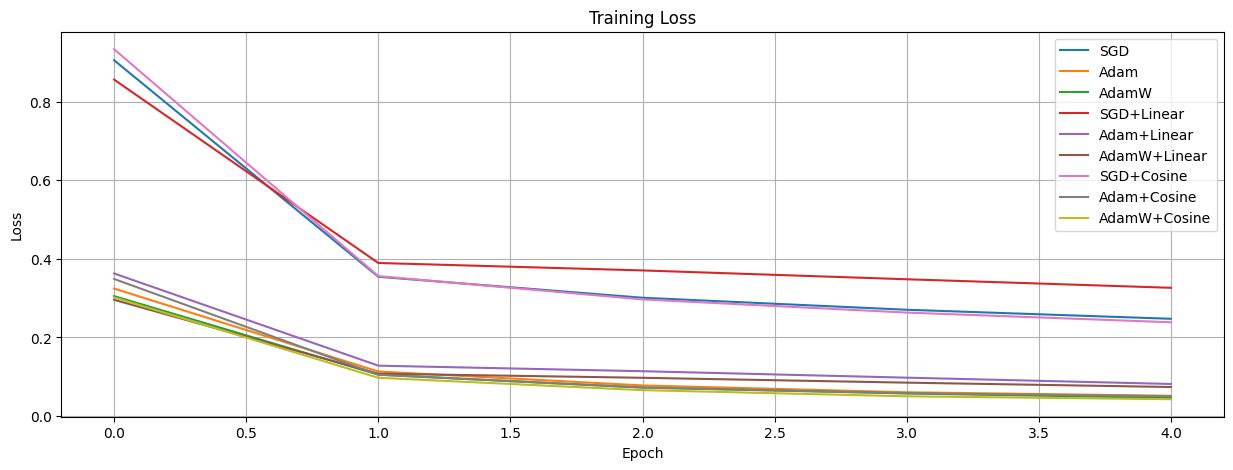

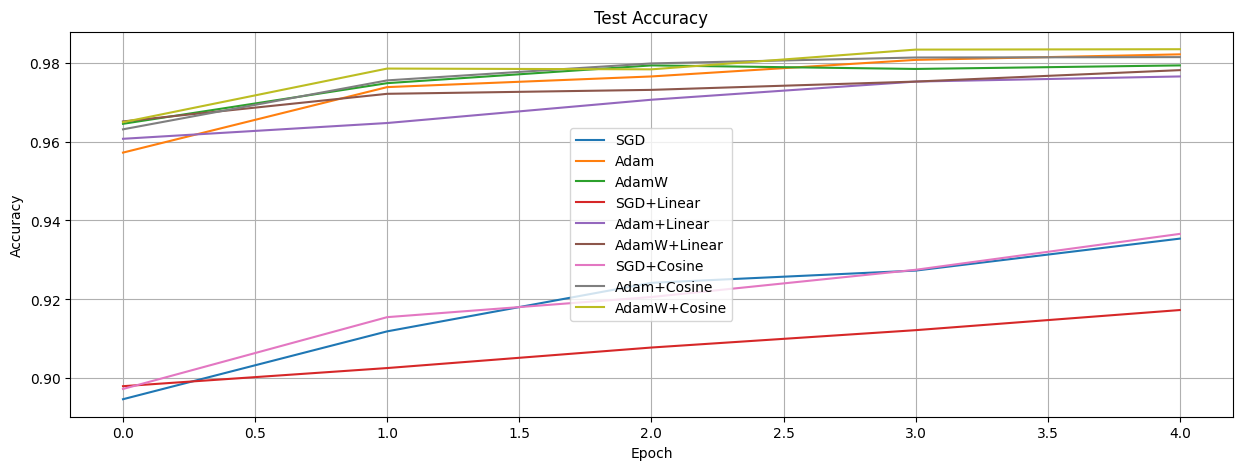

In [28]:
# Loss
plt.figure(figsize=(15, 5))
for name, data in results.items():
    plt.plot(data['losses'], label=name)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(15, 5))
for name, data in results.items():
    plt.plot(data['accuracies'], label=name)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Сравнение SGD,Adam Adamw на игрушечном тесте

In [16]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Adam', Adam, {'lr': 0.3}],
        ['AdamW', AdamW, {'lr': 0.3, 'lymbda': 0.01}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/3 [00:00<?, ?it/s]